## Capture Setup

Setup is somewhat similar to other targets, except that we are using an external clock (driven from the FPGA-- unless you're using the CW312T-A35 target). We'll also do the rest of the setup manually:

In [1]:
import chipwhisperer as cw
scope = cw.scope()
scope.adc.samples = 129
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "disabled"

Before setting the ADC clock, we connect to the CW305 board. Here we'll need to specify our bitstream file to load as well as the usual scope and target_type arguments.

Pick the correct bitfile for your CW305 board (e.g. either '35t' or '100t'). By setting `force=False`, the bitfile will only be programmed if the FPGA is uninitialized (e.g. after powering up). Change to `force=True` to always program the FPGA (e.g. if you have generated a new bitfile).

In [2]:
#TARGET_PLATFORM = 'CW305_100t'
#TARGET_PLATFORM = 'CW305_35t'
TARGET_PLATFORM = 'CW312T_A35'

In [3]:
if TARGET_PLATFORM == 'CW312T_A35':
    scope.gain.db = 45 # this is a good setting for the inductive shunt; if using another, adjust as needed
    scope.io.hs2 = 'clkgen'
    fpga_id = 'cw312t_a35'
    platform = 'ss2'
else:
    scope.gain.db = 25
    scope.io.hs2 = "disabled"
    platform = 'cw305'
    if TARGET_PLATFORM == 'CW305_100t':
        fpga_id = '100t'
    elif TARGET_PLATFORM == 'CW305_35t':
        fpga_id = '35t'

bitfile = '/home/cw/Desktop/ss2_aes_wrapper.bit'
#target = cw.target(scope, cw.targets.CW305, force=True, bsfile = bitfile, platform='ss2')

target = cw.target(scope, cw.targets.CW305, force=True, fpga_id=fpga_id, platform=platform)

(ChipWhisperer Target WARNING|File CW305.py:459) force, sn and hw_location parameters have no effect on this platform


Next we set all the PLLs. We enable CW305's PLL1; this clock will feed both the target and the CW ADC. As explained [here](http://wiki.newae.com/Tutorial_CW305-1_Building_a_Project#Capture_Setup), **make sure the DIP switches on the CW305 board are set as follows**:
- J16 = 0
- K16 = 1

In [4]:
if TARGET_PLATFORM == 'CW305':
    target.vccint_set(1.0)
    # we only need PLL1:
    target.pll.pll_enable_set(True)
    target.pll.pll_outenable_set(False, 0)
    target.pll.pll_outenable_set(True, 1)
    target.pll.pll_outenable_set(False, 2)

    # run at 10 MHz:
    target.pll.pll_outfreq_set(10E6, 1)

    # 1ms is plenty of idling time
    target.clkusbautooff = True
    target.clksleeptime = 1

CW-Husky requires a different setup when the ADC clock is driven by the target:

In [5]:
if TARGET_PLATFORM == 'CW305':
    if scope._is_husky:
        scope.clock.clkgen_freq = 40e6
        scope.clock.clkgen_src = 'extclk'
        scope.clock.adc_mul = 4
        # if the target PLL frequency is changed, the above must also be changed accordingly
    else:
        scope.clock.adc_src = "extclk_x4"

If using the CW312T-A35 target, the capture hardware needs to drive the target clock:

In [6]:
if TARGET_PLATFORM == 'CW312T_A35':
    scope.clock.clkgen_freq = 7.37e6
    scope.io.hs2 = 'clkgen'
    if scope._is_husky:
        scope.clock.clkgen_src = 'system'
        scope.clock.adc_mul = 4
        scope.clock.reset_dcms()
    else:
        scope.clock.adc_src = "clkgen_x4"
    import time
    time.sleep(0.1)
    target._ss2_test_echo()
    

In [7]:
target._ss2_test_echo()

Finally, ensure the ADC clock is locked:

In [8]:
import time
for i in range(5):
    scope.clock.reset_adc()
    time.sleep(1)
    if scope.clock.adc_locked:
        break 
assert (scope.clock.adc_locked), "ADC failed to lock"

Occasionally the ADC will fail to lock on the first try; when that happens, the above assertion will fail (and on the CW-Lite, the red LED will be on). Simply re-running the above cell again should fix things.

## Trace Capture
Below is the capture loop. The main body of the loop loads some new plaintext, arms the scope, sends the key and plaintext, then finally records and appends our new trace to the `traces[]` list.

Because we're capturing 5000 traces, this takes a bit longer than the attacks against software AES implementations.

Note that the encryption result is read from the target and compared to the expected results, as a sanity check.

In [9]:
#Template Attack
project_file = "projects/Tutorial_HW_CW305.cwp"
project = cw.create_project(project_file, overwrite=True)

In [10]:
from tqdm.notebook import tnrange
import numpy as np
import time
from Crypto.Cipher import AES

ktp = cw.ktp.Basic()

traces = []
textin = []
keys = []
N = 10000  # Number of traces

# initialize cipher to verify DUT result:
key, text = ktp.next()
cipher = AES.new(bytes(key), AES.MODE_ECB)

for i in tnrange(N, desc='Capturing traces'):
    # run aux stuff that should come before trace here

    key, text = ktp.next()  # manual creation of a key, text pair can be substituted here
    textin.append(text)
    keys.append(key)
    
    ret = cw.capture_trace(scope, target, text, key)
    if not ret:
        print("Failed capture")
        continue

    assert (list(ret.textout) == list(cipher.encrypt(bytes(text)))), "Incorrect encryption result!\nGot {}\nExp {}\n".format(ret.textout, list(text))
    #trace += scope.getLastTrace()
        
    traces.append(ret.wave)
    project.traces.append(ret)

Capturing traces:   0%|          | 0/10000 [00:00<?, ?it/s]

## Template Attack the first key byte

In [11]:
tempPText = textin
tempKey = keys
tempTraces = traces

In [12]:
sbox=(
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16) 

intermediate = sbox[tempPText[0][0] ^ tempKey[0][0]]

In [13]:
tempSbox = [sbox[tempPText[i][0] ^ tempKey[i][0]] for i in range(len(tempPText))]

In [14]:
hw = [bin(x).count("1") for x in range(256)]
tempHW = [hw[s] for s in tempSbox]

In [15]:
tempTracesHW = [[] for _ in range(9)]

In [16]:
for i in range(len(tempTraces)):
    HW = tempHW[i]
    tempTracesHW[HW].append(tempTraces[i])

In [17]:
tempTracesHW = [np.array(tempTracesHW[HW]) for HW in range(9)]

In [18]:
tempMeans = np.zeros((9, len(tempTraces[0])))

In [19]:
for i in range(9):
    tempMeans[i] = np.average(tempTracesHW[i], 0)

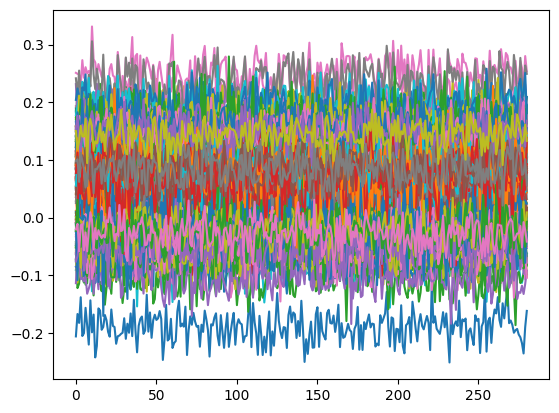

In [21]:

import matplotlib.pyplot as plt
plt.plot(tempTracesHW[1])
plt.show()

In [22]:
len(tempTracesHW[8])

35

In [23]:
tempMeans[5]

array([ 0.1345247 ,  0.07898719, -0.03619338,  0.07856556,  0.13049876,
        0.06689564, -0.04833807,  0.07440565,  0.00086872, -0.0717118 ,
       -0.18730535,  0.04398008,  0.12817261,  0.05836389, -0.02930706,
        0.17110084,  0.21099563,  0.09013085, -0.04649589,  0.11982643,
        0.14265541,  0.01669114, -0.10517877,  0.08886929,  0.14144899,
        0.04237816, -0.06248771,  0.13776562,  0.18121379,  0.06446475,
       -0.05268389,  0.14066851,  0.18375275,  0.07183315, -0.04874531,
        0.13648103,  0.17288068,  0.05697434, -0.06255204,  0.12787798,
        0.17155579,  0.06133909, -0.05509728,  0.13530971,  0.18113861,
        0.07286684, -0.04813169,  0.13319892,  0.1688089 ,  0.06244652,
       -0.06187376,  0.12006858,  0.00420265, -0.02989588, -0.10012257,
        0.12373268,  0.25501977,  0.23626413,  0.11553775,  0.19702846,
        0.19434812,  0.08336024, -0.07088692,  0.02789271,  0.08537969,
        0.04209018, -0.05224643,  0.08803988,  0.16732192,  0.12

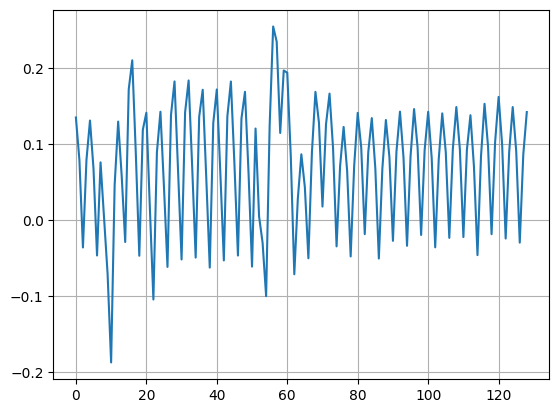

In [24]:
import matplotlib.pyplot as plt
plt.plot(tempMeans[3])
plt.grid()
plt.show()

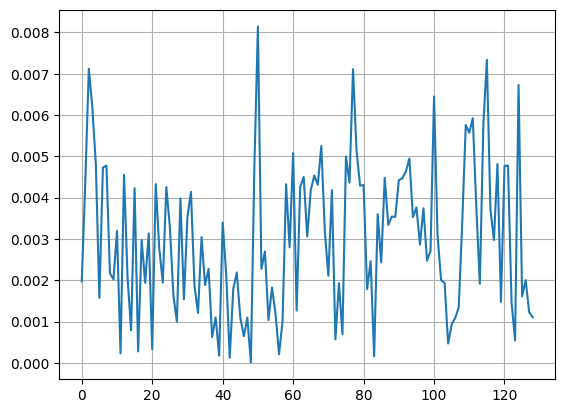

In [25]:
plt.plot(abs(tempMeans[0]-tempMeans[1]))
plt.grid()
plt.show()

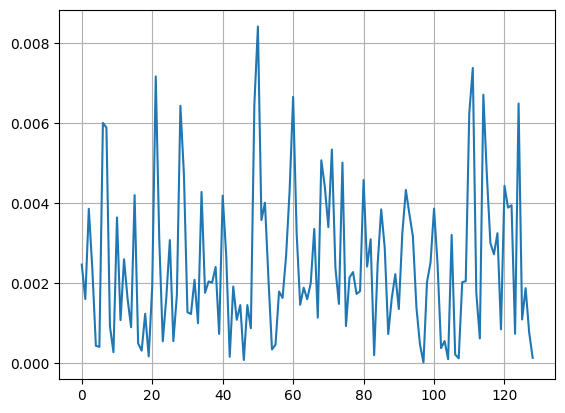

In [26]:
plt.plot(abs(tempMeans[0]-tempMeans[2]))
plt.grid()
plt.show()

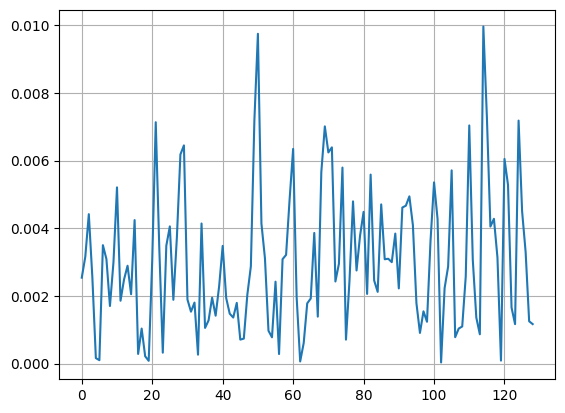

In [27]:
plt.plot(abs(tempMeans[0]-tempMeans[7]))
plt.grid()
plt.show()

In [28]:
tempMeans[8]

array([ 0.14211775,  0.07887835, -0.03697684,  0.07679269,  0.13090123,
        0.0648577 , -0.05      ,  0.07306083,  0.00589425, -0.07222377,
       -0.18620954,  0.04624721,  0.12975725,  0.06436244, -0.02912249,
        0.17040318,  0.2132115 ,  0.09139927, -0.05040458,  0.11699916,
        0.13873465,  0.01918945, -0.0944894 ,  0.0859933 ,  0.1401995 ,
        0.03699777, -0.06731306,  0.13544922,  0.17859933,  0.06368583,
       -0.04926758,  0.14309431,  0.17975028,  0.07446289, -0.05147879,
        0.12784598,  0.1637486 ,  0.0542899 , -0.06368583,  0.12295619,
        0.16683873,  0.05781948, -0.05985631,  0.13754883,  0.18311942,
        0.07647879, -0.04319894,  0.13598633,  0.17162388,  0.06316267,
       -0.06120257,  0.11501116,  0.00404576, -0.03349609, -0.10507812,
        0.12191685,  0.24866769,  0.23269392,  0.11150251,  0.1930106 ,
        0.19259905,  0.08242188, -0.07480469,  0.03148717,  0.08108259,
        0.04128069, -0.05051618,  0.09100865,  0.17189593,  0.13

In [29]:
tempMeans[0]

array([ 0.13656738,  0.0817627 , -0.03168457,  0.08050293,  0.12984863,
        0.06666016, -0.04317871,  0.07925293,  0.00105957, -0.07258789,
       -0.19223145,  0.04348633,  0.13178223,  0.05745605, -0.02743164,
        0.17687988,  0.21075684,  0.0892627 , -0.04614746,  0.11993164,
        0.14368164,  0.02339844, -0.10192383,  0.08912109,  0.14336426,
        0.03805176, -0.06354492,  0.13540527,  0.17545898,  0.06008789,
       -0.0515625 ,  0.14111328,  0.18521484,  0.07212402, -0.04392578,
        0.1349707 ,  0.17386719,  0.05935059, -0.06114258,  0.12669434,
        0.1767627 ,  0.06089355, -0.05294434,  0.13427246,  0.1826416 ,
        0.07135254, -0.04824219,  0.13046387,  0.16786621,  0.05494629,
       -0.0712207 ,  0.11546387, -0.00088867, -0.03242188, -0.10071777,
        0.12475098,  0.25375977,  0.23802246,  0.11835449,  0.20260254,
        0.20188965,  0.08761719, -0.07193848,  0.02647949,  0.08396973,
        0.04102539, -0.05476562,  0.08625488,  0.16230957,  0.12

In [30]:
tempSumDiff = np.zeros(len(tempTraces[0]))

In [31]:
for i in range(9):
    for j in range(i):
        tempSumDiff += np.abs(tempMeans[i] - tempMeans[j])

In [32]:
tempSumDiff

array([0.08214046, 0.04795264, 0.06938618, 0.06604279, 0.05527034,
       0.03305996, 0.07546875, 0.0731048 , 0.07560282, 0.05564331,
       0.06791233, 0.04630301, 0.04911426, 0.08007103, 0.03119542,
       0.06834406, 0.03465733, 0.04679802, 0.06440247, 0.0672506 ,
       0.07069194, 0.09865141, 0.1255694 , 0.05495523, 0.05664914,
       0.08481962, 0.07195633, 0.05423537, 0.08087506, 0.0874411 ,
       0.06110977, 0.06453623, 0.05763268, 0.04310697, 0.08172044,
       0.09399242, 0.09882513, 0.06101155, 0.03219519, 0.05799106,
       0.09976465, 0.06768178, 0.08263679, 0.04232197, 0.0451771 ,
       0.05552426, 0.05405298, 0.06011345, 0.06022435, 0.09216402,
       0.09514699, 0.07644442, 0.06736713, 0.06218551, 0.06488218,
       0.03895179, 0.08555207, 0.07481644, 0.07968105, 0.10344   ,
       0.10049645, 0.06791681, 0.07527723, 0.06882784, 0.06682013,
       0.05317258, 0.06169318, 0.0624796 , 0.09195449, 0.13066594,
       0.08793229, 0.11305575, 0.07359023, 0.07515686, 0.09754

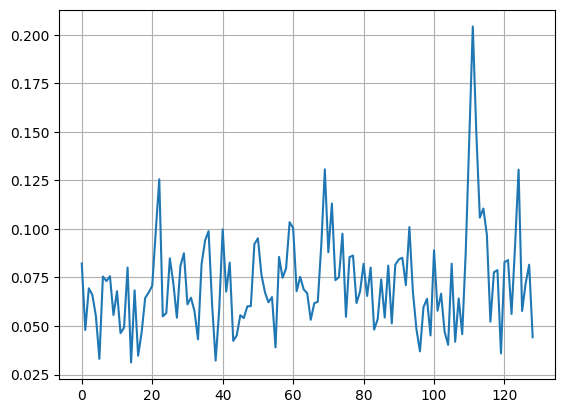

In [33]:
plt.plot(tempSumDiff)
plt.grid()
plt.show()

In [34]:
# Some settings that we can change
numPOIs = 5        # How many POIs do we want?
POIspacing = 5     # How far apart do the POIs have to be?

# Make an empty list of POIs
POIs = []

# Repeat until we have enough POIs
for i in range(numPOIs):
    # Find the biggest peak and add it to the list of POIs
    nextPOI = tempSumDiff.argmax()
    POIs.append(nextPOI)
    
    # Zero out some of the surrounding points
    # Make sure we don't go out of bounds
    poiMin = max(0, nextPOI - POIspacing)
    poiMax = min(nextPOI + POIspacing, len(tempSumDiff))
    for j in range(poiMin, poiMax):
        tempSumDiff[j] = 0

# Make sure they look okay
print(POIs)

[111, 69, 124, 22, 59]


In [35]:
meanMatrix = np.zeros((9, numPOIs))
for HW in range(9):
    for i in range(numPOIs):
        meanMatrix[HW][i] = tempMeans[HW][POIs[i]]

In [36]:
import numpy as np
def cov(x, y):
    # Find the covariance between two 1D lists (x and y).
    # Note that var(x) = cov(x, x)
    return np.cov(x, y)[0][1]

covMatrix  = np.zeros((9, numPOIs, numPOIs))
for HW in range(9):
    for i in range(numPOIs):
        for j in range(numPOIs):
            x = tempTracesHW[HW][:,POIs[i]]
            y = tempTracesHW[HW][:,POIs[j]]
            covMatrix[HW,i,j] = cov(x, y)

In [37]:
print(meanMatrix)
print(covMatrix[0])

[[ 0.09764648  0.12245117  0.15618164 -0.10192383  0.20260254]
 [ 0.09172476  0.1256299   0.14945403 -0.10469462  0.19980434]
 [ 0.0902751   0.12684714  0.14969893 -0.10500365  0.19830294]
 [ 0.0921877   0.12761401  0.14823274 -0.10500508  0.19636169]
 [ 0.08959523  0.12715382  0.14864805 -0.10470128  0.19765169]
 [ 0.09009199  0.12599129  0.14878672 -0.10517877  0.19702846]
 [ 0.09031562  0.12610628  0.14895616 -0.1072906   0.19726984]
 [ 0.09458197  0.12946429  0.14899772 -0.10535976  0.19774519]
 [ 0.10683594  0.13483538  0.14142718 -0.0944894   0.1930106 ]]
[[ 1.66122514e-03  1.47856158e-04  7.52957986e-05  1.37560270e-04
   2.03388954e-04]
 [ 1.47856158e-04  5.76644917e-04 -1.09689771e-04  1.64977677e-04
  -1.58240698e-04]
 [ 7.52957986e-05 -1.09689771e-04  4.76552613e-04  7.15088844e-05
   1.60324817e-05]
 [ 1.37560270e-04  1.64977677e-04  7.15088844e-05  5.80858795e-04
  -8.54163267e-05]
 [ 2.03388954e-04 -1.58240698e-04  1.60324817e-05 -8.54163267e-05
   7.16005077e-04]]


In [38]:

atkTraces = []
atkPText = []
atkKey = []


for i in tnrange(10, desc='Capturing traces'):
    key, text = ktp.next()  # manual creation of a key, text pair can be substituted here
    ret = cw.capture_trace(scope, target, text, key)
    atkTraces.append(ret.wave)
    atkPText.append(text)
    atkKey.append(key)
    

Capturing traces:   0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
print(keys[0][0])

43


In [40]:
P_k = np.zeros(256)

In [41]:
from scipy.stats import multivariate_normal

In [42]:
#result1  10000 traces
for j in range(len(atkTraces)):
    # Grab key points and put them in a matrix
    a = [atkTraces[j][POIs[i]] for i in range(len(POIs))]
    
    # Test each key
    for k in range(256):
        # Find HW coming out of sbox
        HW = hw[sbox[atkPText[j][0] ^ k]]
    
        # Find p_{k,j}
        rv = multivariate_normal(meanMatrix[HW], covMatrix[HW])
        p_kj = rv.pdf(a)
   
        # Add it to running total
        P_k[k] += np.log(p_kj)

    # Print our top 5 results so far
    # Best match on the right
    print(P_k.argsort()[-5:])

[ 65 221 101 127 182]
[ 48 210 116  71 182]
[116  36  60 182  43]
[221 251  60 182  43]
[221  60 176 182  43]
[ 36 116 176 182  43]
[176 126  48 182  43]
[ 48 155 182 180  43]
[ 48 155 182 180  43]
[149 182 155 180  43]


In [43]:
#result2   5000 traces
for j in range(len(atkTraces)):
    # Grab key points and put them in a matrix
    a = [atkTraces[j][POIs[i]] for i in range(len(POIs))]
    
    # Test each key
    for k in range(256):
        # Find HW coming out of sbox
        HW = hw[sbox[atkPText[j][0] ^ k]]
    
        # Find p_{k,j}
        rv = multivariate_normal(meanMatrix[HW], covMatrix[HW])
        p_kj = rv.pdf(a)
   
        # Add it to running total
        P_k[k] += np.log(p_kj)

    # Print our top 5 results so far
    # Best match on the right
    print(P_k.argsort()[-5:])

[173 181 214 139 229]
[ 43 181 163 214 211]
[254 211 181 214 163]
[211 139 214 163 181]
[254  43 181 139 153]
[211 181  43 139 153]
[181  43 139 211 153]
[181 139 211  43 153]
[181 139 211  43 153]
[181 139 211  43 153]


In [64]:
#result3  5000 traces

from scipy.stats import multivariate_normal
# 2: Attack
# Running total of log P_k
P_k = np.zeros(256)
for j in range(len(atkTraces)):
    # Grab key points and put them in a small matrix
    a = [atkTraces[j][POIs[i]] for i in range(len(POIs))]
    
    # Test each key
    for k in range(256):
        # Find HW coming out of sbox
        HW = hw[sbox[atkPText[j][0] ^ k]]
    
        # Find p_{k,j}
        rv = multivariate_normal(meanMatrix[HW], covMatrix[HW])
        p_kj = rv.pdf(a)
   
        # Add it to running total
        P_k[k] += np.log(p_kj)

    # Print our top 5 results so far
    # Best match on the right
    print(P_k.argsort()[-5:])

[207  91 112 148 217]
[207  91 112 148 217]
[ 12 255   3 207  63]
[108 207 206 253 204]
[  4 221 206 204 253]
[255   4 206 204 253]
[ 26 204  43 251 253]
[251 206 172  43 253]
[243   4 135 172 253]
[243  40 172 135 253]
